### 10-701 Machine Learning Project
# Image Caption Generation

Team 26  
Olivier Filion  
Michael Agaby  
Nicholas Amano  

In [1]:
import sys
print(sys.version)
import json
import os
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from collections import defaultdict
import statistics

from torchvision.models import vgg16
import torch
import torch.nn as nn
import numpy as np
import tqdm

from torch.utils.data import DataLoader

3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]


## Utility Functions

In [2]:
import json
import os

def load_captions(path):
    with open(path, "r") as json_file:
        json_dict = json.load(json_file)
    captions = {}
    for annotation in json_dict["annotations"]:
        image_id = annotation["image_id"]
        if image_id not in captions:
            captions[image_id] = []
        captions[image_id].append(annotation["caption"])
    return captions

train_captions = load_captions(os.path.join("dataset", "annotations", "annotations", "captions_train2017.json"))
val_captions = load_captions(os.path.join("dataset", "annotations", "annotations", "captions_val2017.json"))
print(val_captions[139]) 

['A woman stands in the dining area at the table.', 'A room with chairs, a table, and a woman in it.', 'A woman standing in a kitchen by a window', 'A person standing at a table in a room.', 'A living area with a television and a table']


In [3]:
from torchtext.data.utils import get_tokenizer

PUNCTUATION = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
PUNCTUATION_TRANS = str.maketrans("", "", PUNCTUATION)

tokenizer = get_tokenizer("basic_english")
def preprocess_captions(captions):
    preprocessed_captions = {}
    for image_id in captions:
        preprocessed_captions[image_id] = []
        for caption in captions[image_id]:
            caption = caption.translate(PUNCTUATION_TRANS)
            caption = "<start> " + caption.lower().strip() + " <end>"
            caption = tokenizer(caption)
            preprocessed_captions[image_id].append(caption)
    return preprocessed_captions

preprocessed_train_captions = preprocess_captions(train_captions)
preprocessed_val_captions = preprocess_captions(val_captions)
print(preprocessed_val_captions[139])

[['<start>', 'a', 'woman', 'stands', 'in', 'the', 'dining', 'area', 'at', 'the', 'table', '<end>'], ['<start>', 'a', 'room', 'with', 'chairs', 'a', 'table', 'and', 'a', 'woman', 'in', 'it', '<end>'], ['<start>', 'a', 'woman', 'standing', 'in', 'a', 'kitchen', 'by', 'a', 'window', '<end>'], ['<start>', 'a', 'person', 'standing', 'at', 'a', 'table', 'in', 'a', 'room', '<end>'], ['<start>', 'a', 'living', 'area', 'with', 'a', 'television', 'and', 'a', 'table', '<end>']]


In [4]:
from torchtext.vocab import build_vocab_from_iterator

def create_vocabulary(tokenized_captions):
    all_tokens = []
    for image_id in tokenized_captions:
        for caption in tokenized_captions[image_id]:
            all_tokens += caption
    return build_vocab_from_iterator([all_tokens], min_freq=1, specials=["<unk>", "<null>"])

vocabulary = create_vocabulary(preprocessed_train_captions)
print(len(vocabulary))

28951


In [5]:
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Resize, CenterCrop, Normalize
from functools import lru_cache

# Changed from 256 to 224 for googlenet implementation
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

class CaptionDataset(Dataset):

    def __init__(self, image_folder, preprocessed_captions, vocab, max_caption_length=22):
        self.image_folder = image_folder
        self.captions = preprocessed_captions
        self.vocab = vocab
        self.indices = [(image_id, caption_id)
                        for image_id in preprocessed_captions
                        for caption_id in range(len(preprocessed_captions[image_id]))
                        if len(preprocessed_captions[image_id][caption_id]) <= max_caption_length]
        self.tensor_transform = ToTensor()
        self.scale_transform = Resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        self.crop_transform = CenterCrop((224,224))
        # ******** might not be normalizing Correctly should investigate **********
        self.norm_transform = Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        self.max_caption_length = max_caption_length # includes <start> and <end> tokens, captions shorter than this will be padded with <null> tokens
        # Instantiate CNN model and remove 
        self.CNN = vgg16(pretrained=True)
        self.CNN.fc = nn.Linear(in_features = 1024, out_features= 512)
    
    def __len__(self):
        return len(self.indices)

    @lru_cache(maxsize=128)
    def _get_image(self, image_id, crop_and_scale, convolve):
        image_str = str(image_id)
        image_filename = "0" * (12 - len(image_str)) + image_str + ".jpg"
        image_path = os.path.join(self.image_folder, image_filename)
        image = Image.open(image_path)

        if crop_and_scale:
            image = self.scale_transform(image)
            image = self.crop_transform(image)
            image = self.tensor_transform(image)
            image = self.norm_transform(image)
            if convolve:
                image = self.CNN(image.unsqueeze(0))
            return image
        
        
            
        return self.tensor_transform(image)

    def __getitem__(self, idx, crop_and_scale=True, convolve = True):
        image_id, caption_id = self.indices[idx]
        
        image_tensor = self._get_image(image_id, crop_and_scale, convolve)

        caption = self.captions[image_id][caption_id]
        labels = torch.zeros(self.max_caption_length, 1)
        for i in range(self.max_caption_length):
            token = ("<null>" if i >= len(caption)
                     else caption[i] if caption[i] in self.vocab
                     else "<unk>")
            labels[i][0] = self.vocab[token]
        return image_tensor, labels
  

# Visualizing Some Data

torch.Size([3, 400, 400])
tensor([[4.0000e+00],
        [2.0000e+00],
        [3.5600e+02],
        [3.8110e+03],
        [9.0000e+00],
        [2.0000e+00],
        [8.3000e+01],
        [1.2200e+02],
        [7.0000e+00],
        [4.0000e+01],
        [1.0880e+03],
        [3.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00]])
['<start>', 'a', 'bicycle', 'replica', 'with', 'a', 'clock', 'as', 'the', 'front', 'wheel', '<end>']


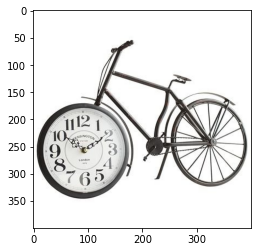

In [6]:
import matplotlib.pyplot as plt

train_ds = CaptionDataset(os.path.join("dataset", "train", "train2017"), preprocessed_train_captions, vocabulary)

im, l = train_ds.__getitem__(0, False)
print(im.shape)
print(l)
print(preprocessed_train_captions[train_ds.indices[0][0]][train_ds.indices[0][1]])

plt.imshow(im.permute((1, 2, 0)))
plt.show()

['<start>', 'a', 'bathroom', 'with', 'a', 'toilet', 'sink', 'and', 'shower', '<end>']


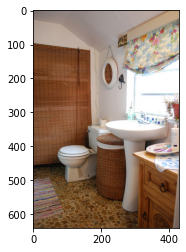

In [7]:
im, l = train_ds.__getitem__(20, False)
print(preprocessed_train_captions[train_ds.indices[20][0]][train_ds.indices[20][1]])

plt.imshow(im.permute((1, 2, 0)))
plt.show()

['<start>', 'a', 'car', 'that', 'seems', 'to', 'be', 'parked', 'illegally', 'behind', 'a', 'legally', 'parked', 'car', '<end>']
['<start>', 'two', 'cars', 'parked', 'on', 'the', 'sidewalk', 'on', 'the', 'street', '<end>']
['<start>', 'city', 'street', 'with', 'parked', 'cars', 'and', 'a', 'bench', '<end>']
['<start>', 'cars', 'try', 'to', 'maneuver', 'into', 'parking', 'spaces', 'along', 'a', 'densely', 'packed', 'city', 'street', '<end>']
['<start>', 'a', 'couple', 'of', 'cars', 'parked', 'in', 'a', 'busy', 'street', 'sidewalk', '<end>']


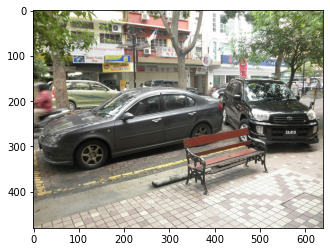

In [8]:
# an example of all 5 captions for one image
im, l = train_ds.__getitem__(10, False)
print(preprocessed_train_captions[train_ds.indices[10][0]][0])
print(preprocessed_train_captions[train_ds.indices[10][0]][1])
print(preprocessed_train_captions[train_ds.indices[10][0]][2])
print(preprocessed_train_captions[train_ds.indices[10][0]][3])
print(preprocessed_train_captions[train_ds.indices[10][0]][4])
plt.imshow(im.permute((1, 2, 0)))
plt.show()

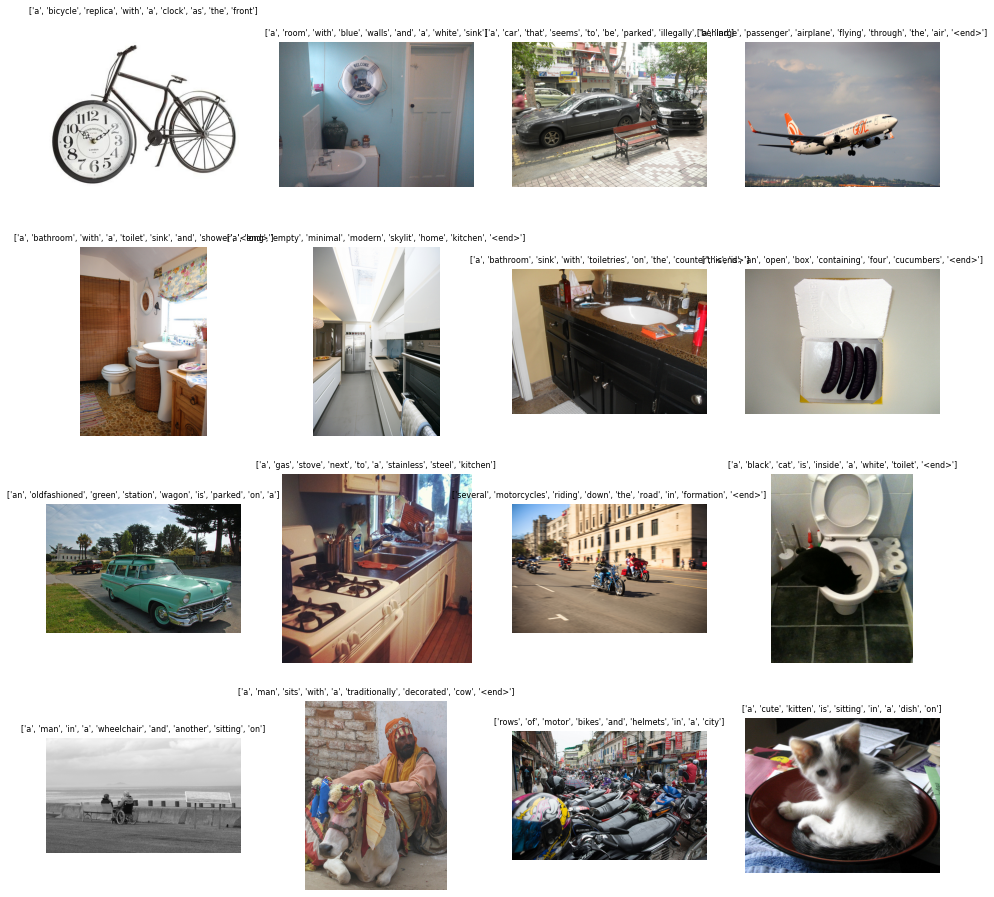

In [9]:
# 16 images as well as the first few wordsw of one of their captions
plt.subplots(figsize=(16,16))

for i in range(16):
    im, l = train_ds.__getitem__(5*i, False)
    plt.subplot(4,4,i+1)
    plt.title(preprocessed_train_captions[train_ds.indices[5*i][0]][0][1:10], fontsize=8)
    plt.imshow(im.permute((1, 2, 0)))
    plt.axis("off")
plt.show()

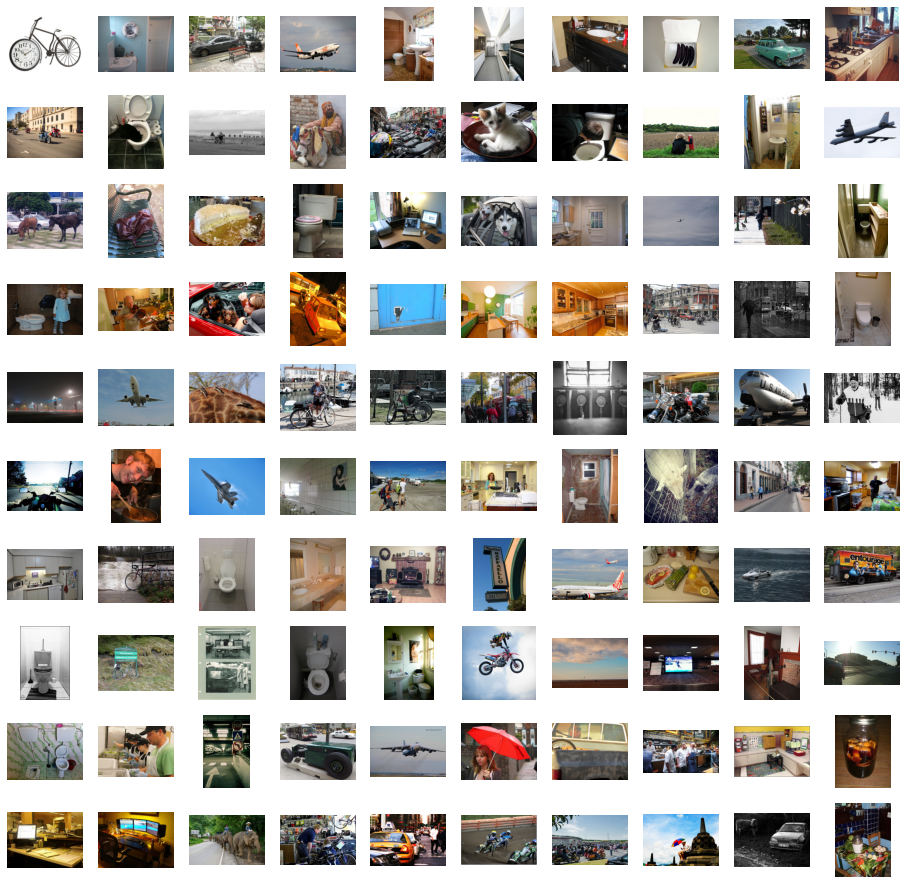

In [10]:
# first 100 images:
plt.subplots(figsize=(16,16))

for i in range(100):
    im, l = train_ds.__getitem__(5*i, False)
    plt.subplot(10,10,i+1)
    plt.imshow(im.permute((1, 2, 0)))
    plt.axis("off")
plt.show()

### Aspect Ratios

Estimating the histogram of aspect ratios by random sampling

0
10000
20000
30000
40000


(array([ 15.,  52., 142., 183., 140., 150., 121., 120., 135., 122.,  64.,
         61.,  37.,  32.,  26.,  23.,  16.,  16.,  12.,  11.,   9.,  10.,
          8.,   5.,   2.,   5.,   1.,   3.,   2.,   1.,   2.,   2.,   3.,
          2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.]),
 array([0.3234375 , 0.44490435, 0.56637119, 0.68783804, 0.80930489,
        0.93077173, 1.05223858, 1.17370543, 1.29517228, 1.41663912,
        1.53810597, 1.65957282, 1.78103966, 1.90250651, 2.02397336,
        2.1454402 , 2.26690705, 2.3883739 , 2.50984075, 2.63130759,
        2.75277444, 2.87424129, 2.99570813, 3.11717498, 3.23864183,
        3.36010867, 3.48157552, 3.60304237, 3.72450921, 3.84597606,
        3.96744291, 4.08890976, 4.2103766 , 4.33184345, 4.4533103 ,
        4.57477714, 4.69624399, 4.81771084, 4.93917768, 5.06064453,
        5.18211138, 5.30357823, 5.42504507, 5.54651192, 5.66797877,
        5.78944561, 5.91091246, 6.03237931, 6.15384615]),


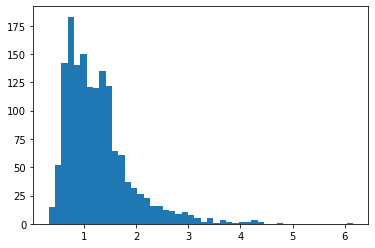

In [298]:
from collections import defaultdict
import random

ratios = defaultdict(float)

for i in range(50000):
    indx = random.randint(0, len(train_ds))
    if(i%10000==0):
        print(i)
    im, l = train_ds.__getitem__(indx, False)
    h, w = im.shape[1], im.shape[2]
    ratios[w/h]+=1
plt.hist(ratios, bins='auto') 

### Area

Estimating histogram of area by random sampling


0
10000
20000
30000
40000


(array([1541.,   17.,   25.,   42.,   74.,  123.,  110.,  124.,  108.,
         117.,   76.,   56.,   47.,   41.,   45.,   44.]),
 array([3.23437500e-01, 2.56003032e+04, 5.12002830e+04, 7.68002628e+04,
        1.02400243e+05, 1.28000222e+05, 1.53600202e+05, 1.79200182e+05,
        2.04800162e+05, 2.30400142e+05, 2.56000121e+05, 2.81600101e+05,
        3.07200081e+05, 3.32800061e+05, 3.58400040e+05, 3.84000020e+05,
        4.09600000e+05]),
 <BarContainer object of 16 artists>)

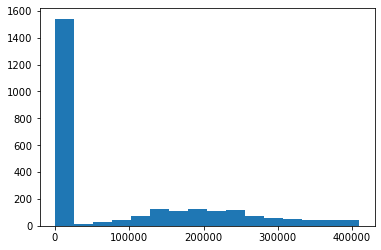

In [299]:
areas = defaultdict(float)

for i in range(50000):
    indx = random.randint(0, len(train_ds))
    if(i%10000==0):
        print(i)
    im, l = train_ds.__getitem__(indx, False)
    h, w = im.shape[1], im.shape[2]
    ratios[h*w]+=1
plt.hist(ratios, bins='auto') 

### Finding the most common words 

In [41]:
counts = defaultdict(int)

for captions in preprocessed_train_captions.values():
    for caption in captions:
        for word in caption:
            counts[word]+=1
        
    

In [42]:
sorted_counts = sorted(counts, key=counts.get, reverse=True)
conjuncts = ['has','small','while','some','down','to','<start>','<end>','a','.','on','of','the','in','with','and', 'is', 'an', 'two', 'one', 'at', 'are', 'next'
            ,'there','side','other','is', 'it', 'that','near', 'the', 'his', 'her', 'they', 'up', 'top', ',', ':', ';', '\''
            ,'by','large','front','back']

for word in conjuncts:
    if(word in sorted_counts):
        sorted_counts.remove(word)
    
print(sorted_counts[0:50])

['man', 'sitting', 'standing', 'people', 'white', 'woman', 'street', 'table', 'holding', 'person', 'group', 'field', 'tennis', 'black', 'train', 'plate', 'room', 'dog', 'riding', 'red', 'cat', 'young', 'water', 'baseball', 'playing', 'walking', 'bathroom', 'sign', 'blue', 'kitchen', 'food', 'grass', 'bus', 'pizza', 'green', 'parked', 'building', 'bed', 'looking', 'snow', 'beach', 'ball', 'couple', 'three', 'for', 'boy', 'men', 'toilet', 'clock', 'city']


### Distribution of caption lengths

Average caption length:  10.481263297355484
Median caption length:  10
Shortest caption length:  5
Longest caption length:  49


(array([1.00000e+00, 1.40000e+01, 4.68900e+03, 9.73020e+04, 1.27819e+05,
        1.26721e+05, 9.11360e+04, 5.83730e+04, 3.41950e+04, 1.96070e+04,
        1.13360e+04, 6.83300e+03, 4.20700e+03, 2.71700e+03, 1.88400e+03,
        1.28300e+03, 9.16000e+02, 6.66000e+02, 4.87000e+02, 3.23000e+02,
        2.55000e+02, 1.78000e+02, 1.73000e+02, 8.80000e+01, 7.00000e+01,
        5.90000e+01, 5.60000e+01, 4.40000e+01, 4.60000e+01, 4.70000e+01,
        3.00000e+01, 1.90000e+01, 2.30000e+01, 1.70000e+01, 2.30000e+01,
        2.30000e+01, 1.50000e+01, 1.30000e+01, 2.30000e+01, 1.40000e+01,
        7.00000e+00, 7.00000e+00, 9.00000e+00, 5.00000e+00]),
 array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
        18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
        31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
        44., 45., 46., 47., 48., 49.]),
 <BarContainer object of 44 artists>)

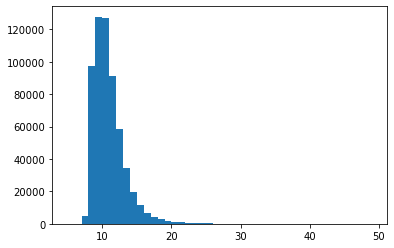

In [38]:
import statistics
lengths = []
for captions in preprocessed_train_captions.values():
    for caption in captions:
        lengths.append(len(caption)-2)
        
print("Average caption length: ", sum(lengths)/len(lengths))
print("Median caption length: ", statistics.median(lengths))
print("Shortest caption length: ", min(lengths))
print("Longest caption length: ", max(lengths))
plt.hist(lengths, bins=max(lengths)-min(lengths)) 

We see a clear right skew in the distribution of caption lengths

### Get frequency cutoff

In [56]:
sorted_counts = (sorted(counts.values(),reverse=True))
print(sorted_counts[7411])

10


# Visualizing Activations

In [8]:
from torchvision.models import vgg16 #googlenet, 
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import glob
import torch
import os
from mpl_toolkits.axes_grid1 import ImageGrid
import copy
from torch.autograd import Variable

In [14]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

def get_image(file_path):
    image_path = file_path
    image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
   
  
    img=transform(image)
    img=img.unsqueeze(0)
    return img

In [9]:
CNN = vgg16(pretrained=True)
CNN.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [9]:
convs = [0,2,5,7,10,12,14,17,19,21,24,26,28]

## First conv layer

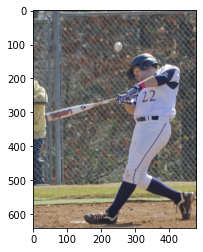

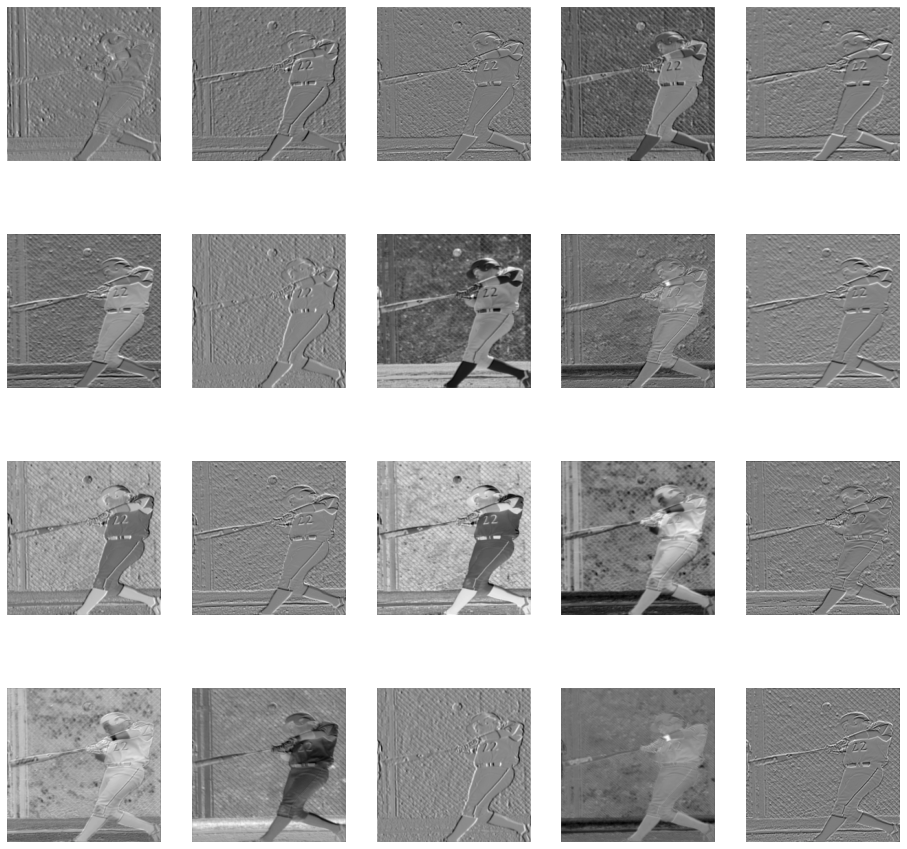

In [60]:
file_path = './dataset/test/test2017/000000000016.jpg'
img = Image.open(file_path)
plt.imshow(img)
visualize_nth_convolution(CNN, file_path,0)

In [12]:
# visualized after layer #n, has to be aconvolutional layer
def visualize_nth_convolution(model, file_path, layer_num):
    img = get_image(file_path)
    convolved = model.features[0](img)
    for i in range(1, layer_num+1):
        layer = model.features[i]
        convolved = layer(convolved)
        
    plt.subplots(figsize=(16,16))
   
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(convolved[0, :, :, :][i].detach().numpy(), cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()
    

### Second conv layer

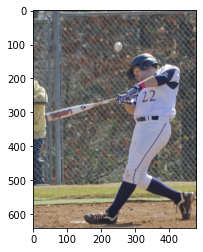

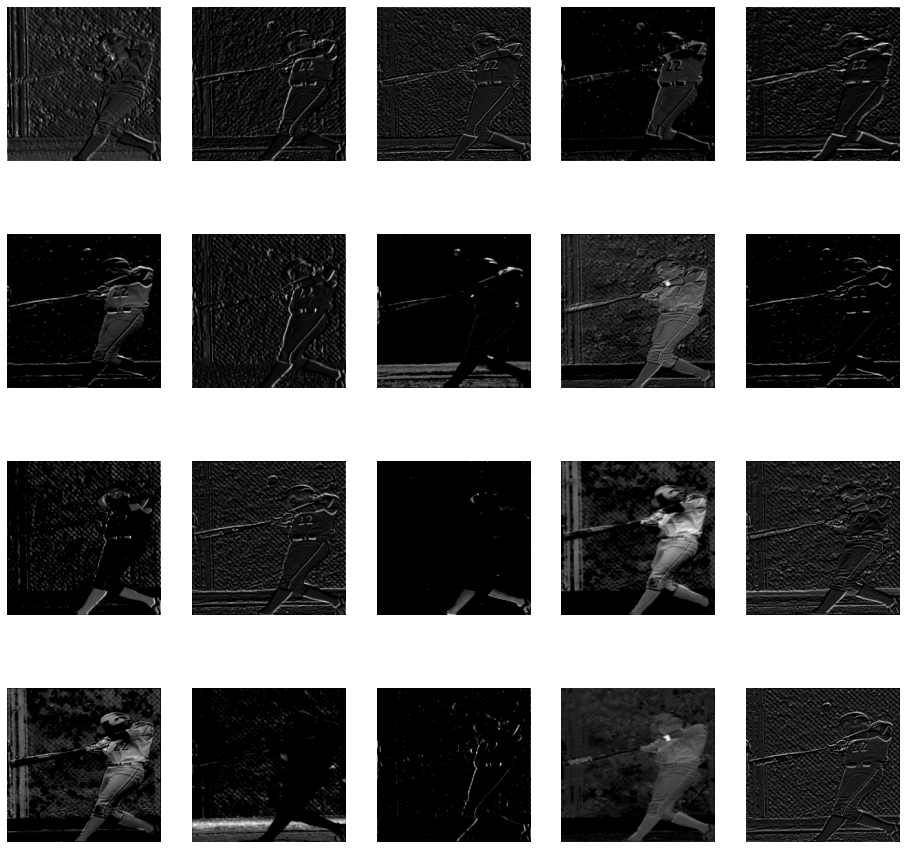

In [61]:
file_path = './dataset/test/test2017/000000000016.jpg'
img = Image.open(file_path)
plt.imshow(img)
visualize_nth_convolution(CNN, file_path,2)

## Third conv layer

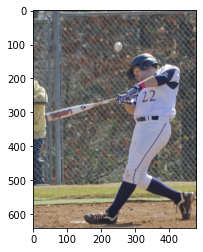

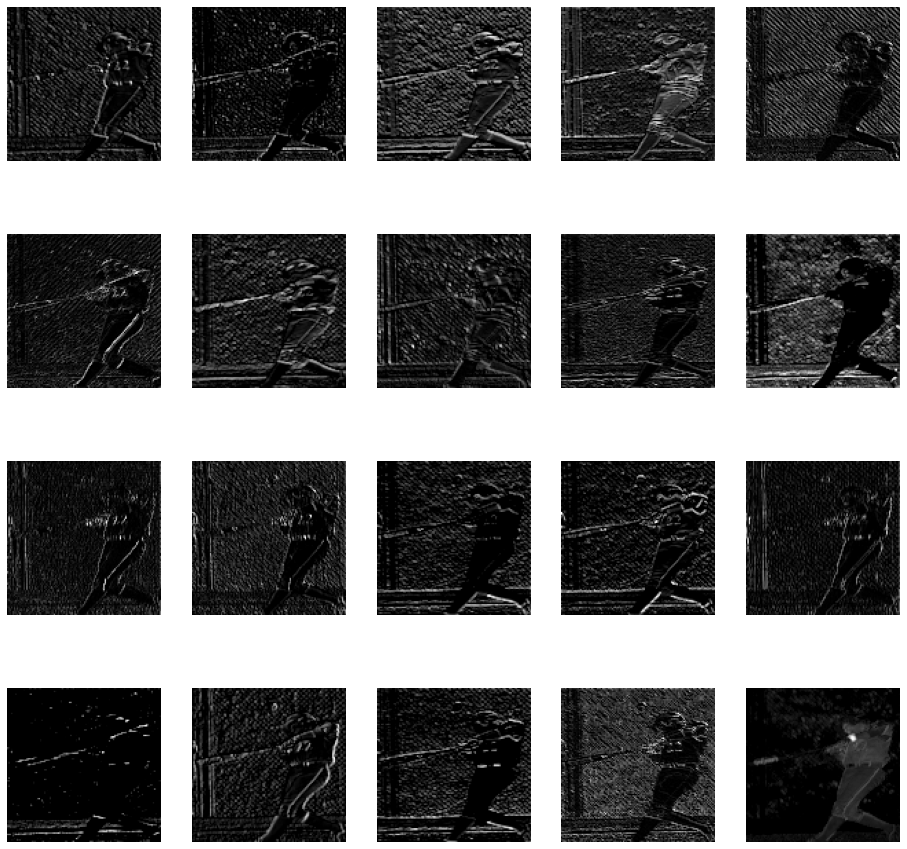

In [62]:
file_path = './dataset/test/test2017/000000000016.jpg'
img = Image.open(file_path)
plt.imshow(img)
visualize_nth_convolution(CNN, file_path,5)

# Visualizing Convolutions

In [106]:
def activation_maximization(model, layer_num, filter_num):
        
        # initiate a random image
    rand_im = np.uint8(np.random.uniform(0, 255, (224, 224, 3)))
    rand_im = Image.fromarray(rand_im)
        #transform img
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
   
    img=transform(rand_im)
    img = img.unsqueeze(0)
    img_var = Variable(img,requires_grad=True)
        
    optimizer = torch.optim.Adam([img_var], lr=0.05,weight_decay=0.000001)
    

    
    for i in range(30):
        
        optimizer.zero_grad()
            
        temp = img_var
            
            # move forward through the network until the selected layer
        for j in range(layer_num+1):
            layer = model.features[j]
            temp = layer(temp)
            #temp = 2*temp
        
            # get current filter
        output = temp[0, filter_num]
        
        loss = -1*torch.mean(output)
        loss.backward()
            
        optimizer.step()
        
        new_im = copy.copy(img_var.data.numpy()[0])
        
        for channel in range(3):
        
            new_im[channel] /= [1/0.229, 1/0.224, 1/0.225][channel]
            new_im[channel] -= [-0.485, -0.456, -0.406][channel]
        
        new_im[new_im > 1] = 1
        new_im[new_im < 0] = 0
        new_im = np.round(new_im * 255)
        new_im = np.uint8(new_im).transpose(1, 2, 0)
          
    
        #print(img_var)
        
    
    plt.imshow(new_im)
    plt.axis("off")
    plt.show()
   

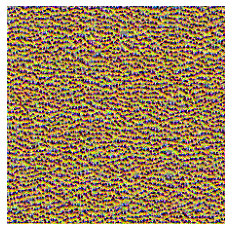

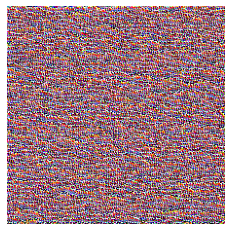

In [110]:
# layer 2, filter 10
activation_maximization(CNN,3,12)
    
# layer 2, filter 20
activation_maximization(CNN,6,20)
    

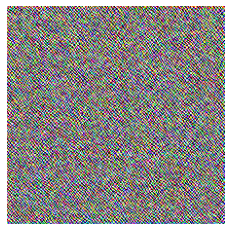

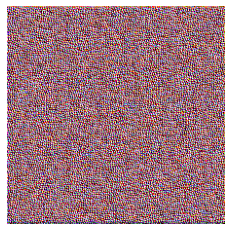

In [26]:
# layer 5, filter 10
activation_maximization(CNN,5,30)
    
# layer 5, filter 20
activation_maximization(CNN,5,20)

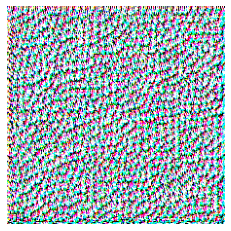

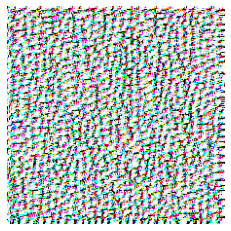

In [279]:
# layer 12, filter 10
activation_maximization(CNN,12,10)
    
# layer 12, filter 20
activation_maximization(CNN,12,20)

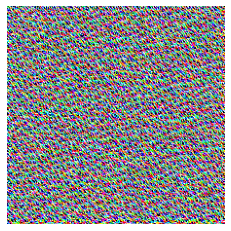

In [111]:
# layer 11, filter 10
activation_maximization(CNN,11,10)

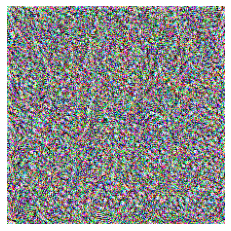

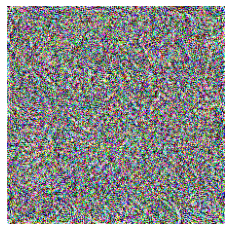

In [339]:
# layer 28, filter 100
activation_maximization(CNN,28,100)
    
# layer 28, filter 300
activation_maximization(CNN,28,300)

In [35]:
def deep_dream(model, layer_num, filter_num, file_path):
    
    img = get_image(file_path)
    img_var = Variable(img,requires_grad=True)
        
    optimizer = torch.optim.Adam([img_var], lr=0.1,weight_decay=0.000001)
 
    for i in range(30):
        
        optimizer.zero_grad()
            
        temp = img_var
            
        # move forward through the network until the selected layer
        for j in range(layer_num+1):
            layer = model.features[j]
            temp = layer(temp)
        
        # get current filter
        output = temp[0, filter_num]
        
        loss = -1*torch.mean(output)
        loss.backward()
            
        optimizer.step()
        
        new_im = copy.copy(img_var.data.numpy()[0])
        
        for channel in range(3):
        
            new_im[channel] /= [1/0.229, 1/0.224, 1/0.225][channel]
            new_im[channel] -= [-0.485, -0.456, -0.406][channel]
        
        new_im[new_im > 1] = 1
        new_im[new_im < 0] = 0
        new_im = np.round(new_im * 255)
        new_im = np.uint8(new_im).transpose(1, 2, 0)
          
    
        #print(img_var)
        
    
    plt.imshow(new_im)
    plt.axis("off")
    plt.show()
    

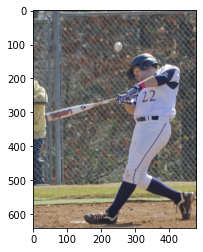

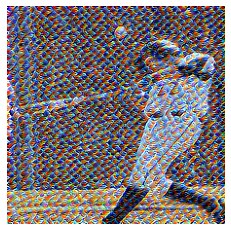

In [29]:
file_path = './dataset/test/test2017/000000000016.jpg'
img = Image.open(file_path)
plt.imshow(img)
plt.show()
# layer 12, filter 2
deep_dream(CNN, 12, 2, file_path)

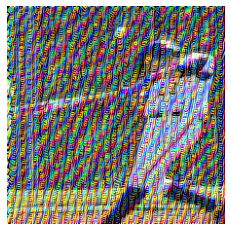

In [30]:
#layer 12, filter 60
deep_dream(CNN, 12, 60, file_path)

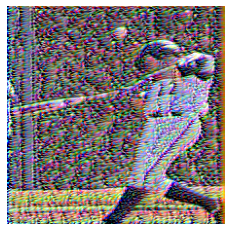

In [31]:
#layer 7, filter 12
deep_dream(CNN, 7, 12, file_path)

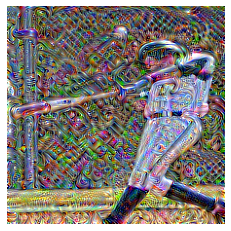

In [32]:
#layer 28, filter 500
deep_dream(CNN, 28, 500, file_path)

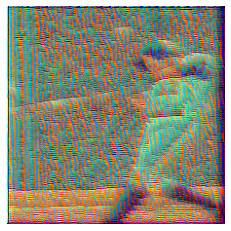

In [36]:
#layer 2, filter 63
deep_dream(CNN, 2, 63, file_path)

# Saliency Maps

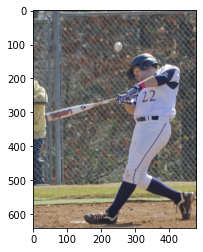

In [17]:
file_path = './dataset/test/test2017/000000000016.jpg'
img = Image.open(file_path)
plt.imshow(img)
plt.show()

In [169]:
def saliency_map(path, model, index = 0):
    # set to eval mode
    model.eval()
    #don't need gradient wrt weights
    for param in model.parameters():
        param.requires_grad = False
    # get the tensor
    img = get_image(path)
    # we want the gradient wrt input
    img.requires_grad = True
    # pass the input into the model
    output = model(img)
    # retrieve max
   
    if index == 0:
        output_idx = output.argmax()
        output_max = output[0, output_idx]
    
    else:
        output_idx = index
        output_max = output[0, output_idx]
    # backwards pass
    output_max.backward()
    # get the max along each channel
    saliency, _ = torch.max(torch.abs(img.grad[0]), dim=0) 
    #inverse transform
    new_im = copy.copy(img.data.numpy()[0])
    for channel in range(3):
        
        new_im[channel] /= [1/0.229, 1/0.224, 1/0.225][channel]
        new_im[channel] -= [-0.485, -0.456, -0.406][channel]
        
    new_im[new_im > 1] = 1
    new_im[new_im < 0] = 0
    new_im = np.round(new_im * 255)
    new_im = np.uint8(new_im).transpose(1, 2, 0)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(new_im)
    plt.subplot(1, 2, 2)
    plt.imshow(saliency.numpy(), cmap=plt.cm.hot)
    plt.show()
    

tensor(981)


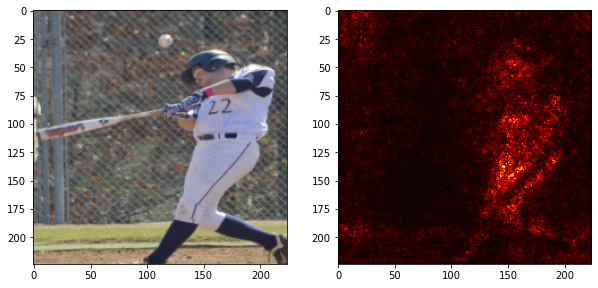

In [170]:
saliency_map('./dataset/test/test2017/000000000016.jpg',CNN)

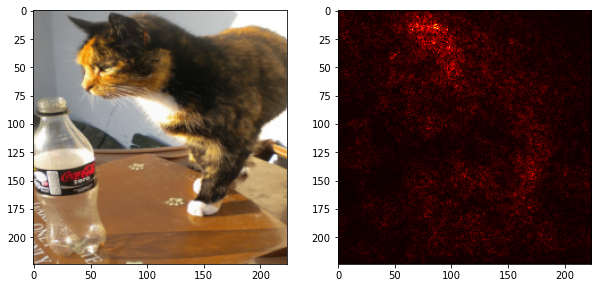

In [203]:
saliency_map('./dataset/train/train2017/000000002471.jpg',CNN,282)

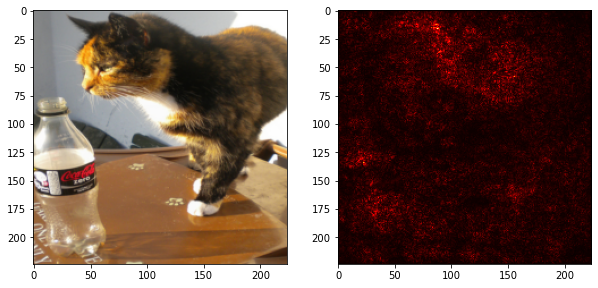

In [205]:
saliency_map('./dataset/train/train2017/000000002471.jpg',CNN,737)

In [141]:
import json
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]


In [206]:
for i in range(len(idx2label)):
    if(idx2label[i]=='water_bottle'):
        print(i)

898


In [201]:
idx2label

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house_finch',
 'junco',
 'indigo_bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water_ouzel',
 'kite',
 'bald_eagle',
 'vulture',
 'great_grey_owl',
 'European_fire_salamander',
 'common_newt',
 'eft',
 'spotted_salamander',
 'axolotl',
 'bullfrog',
 'tree_frog',
 'tailed_frog',
 'loggerhead',
 'leatherback_turtle',
 'mud_turtle',
 'terrapin',
 'box_turtle',
 'banded_gecko',
 'common_iguana',
 'American_chameleon',
 'whiptail',
 'agama',
 'frilled_lizard',
 'alligator_lizard',
 'Gila_monster',
 'green_lizard',
 'African_chameleon',
 'Komodo_dragon',
 'African_crocodile',
 'American_alligator',
 'triceratops',
 'thunder_snake',
 'ringneck_snake',
 'hognose_snake',
 'green_snake',
 'king_snake',
 'garter_snake',
 'water_snake',
 'vine_snake',
 'night_snake',
 'boa_constrictor',
 'rock_python',
 'Indian_cobr

# Attention

In [246]:
import os
import torch
import preprocessing
import dataset
import model as mod

In [241]:
caption_model = torch.load("attention/check_att20.pt")

In [242]:
vocab = caption_model.decoder.vocab

In [249]:
im = torch.load(os.path.join("dataset", "features", "train", "mp", '000000001319.pt'))

In [244]:
pred, weights = mod.inference_attention(caption_model, im, True)

In [ ]:
print("Model output:", preprocessing.rebuild_sentence(pred[0], vocab))

In [ ]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

# get cropped image
def get_image_cropped(file_path):
    image_path = file_path
    image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor()
    ])
   
  
    img=transform(image)
    img=img.unsqueeze(0)
    return img

In [ ]:
# get the attention plot
def attention_plot(file,im_file, model,vocab):
    im= torch.load(file)
    pred, weights = mod.inference_attention(caption_model, im, True)
    sentence = preprocessing.rebuild_sentence(pred[0], vocab).split(" ")
    image = get_image_cropped(im_file)
    image = image.data.numpy()[0]*255
    image = np.uint8(image).transpose(1, 2, 0)
    print(image.shape)
    fig = plt.figure(figsize=(50, 50))
    for i in range(len(sentence)):
        attention_plot =  weights[0][i+1].view([7,7]).detach().numpy()
        grid_size = max(np.ceil(len(sentence)/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(sentence[i],fontsize=80)
        temp = ax.imshow(image)
        ax.imshow(attention_plot, cmap='gray', alpha=0.7, extent=temp.get_extent())
        

In [ ]:
# attention plot
file1 = os.path.join("dataset", "features", "val", "mp", '000000139872.pt')
file2 = './dataset/val/val2017/000000139872.jpg'
attention_plot(file1,file2, caption_model,vocab)

In [ ]:
# saliency map
saliency_map('./dataset/val/val2017/000000139872.jpg',CNN,430)